In [3]:
# run this cell to ensure course package is installed
import sys
from pathlib import Path

course_tools_path = Path('../../Lessons/Course_Tools/').resolve() # change this to the local path of the course package
sys.path.append(str(course_tools_path))

from install_introdl import ensure_introdl_installed
ensure_introdl_installed(force_update=False, local_path_pkg= course_tools_path / 'introdl')

The `introdl` module is already installed.


In [5]:
# add your imports and settings here
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchinfo import summary
from sklearn.metrics import accuracy_score
import numpy as np

from matplotlib import pyplot as plt 
import seaborn as sns

from introdl.utils import get_device, load_results, load_model, config_paths_keys, summarizer
from introdl.idlmam import train_simple_network, visualize2DSoftmax
from introdl.visul import plot_training_metrics

from sklearn.model_selection import train_test_split
from helper_scripts import make_spirals

from introdl.utils import config_paths_keys

paths = config_paths_keys()
MODELS_PATH = paths['MODELS_PATH']
DATA_PATH = paths['DATA_PATH']


MODELS_PATH=.
DATA_PATH=.
TORCH_HOME=.
HF_HOME=.


# Binary classification of 2D points arranged in a spiral

## Instructions

Read these carefully to be sure you don't leave anything out.

Start by playing with the 2 class spiral classification problem in the [Neural Network Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=35&networkShape=4,2&seed=0.76765&showTestData=false&discretize=false&percTrainData=80&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&problem_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&regularizationRate_hide=true).  Note - this link gives you a reduced version of the original website so you can focus on mainly the structure of the NN for this assignment.  

Don't change the test/training ratio or the noise level.  Also, use only X1 and X2 as features (inputs) for your network.  Experiment with the network structure and try retraining each network a few times until you find a network architecture that seems to work reasonably well.  Once you've done that  you should implement that network here in PyTorch.  

We'll generate the initial spiral data for you.  You do the rest.  You should mimic the setup in the compact version of the logisitic regression notebook from class (in Canvas), but make changes to the network, training loop, etc. as needed.

In addition to plotting the loss for the training and validation sets vs the epochs, figure out how to do the same for accuracy and share that plot.

In the end you should be able to achieve 95% accuracy on the validation data.  I'll likely change a couple of random seeds to see if you've picked a robust architecture and training parameters!


## Describe what you learned in NN Playground [5 pts]

Use this cell to explain what you learned in NN playground.  What model did you select?  What learning rate?  What activation function?

FILL IN HERE: 

I found that using three hidden layers created the most consistent and accurate model. Specifically, the first and second hidden layers (h1 and h2) needed to have 7-8 nodes, while the third hidden layer (h3) performed better with slightly fewer nodes; 6 seemed to work well.

Learning rates of 0.1 and 0.003 both did a good job of tuning the model in a correct and short time. The higher learning rate of 0.1 could create an accurate model in a shorter amount of time. However, when creating my own model, I found that 0.1 was a little "volatile" and could result in large fluctuations in loss throughout the training. A learning rate of 0.003 was more steady.

The ReLU activation function was the only activation function that could tune the model correctly. The others experienced very little change in loss and never converged on a solution.


## Prepare the data. [5 pts]

We'll build the spirals and split the data into train and test sets.  We're using a larger training set than in NN playground for more robust training.  Don't modify this code.


In [6]:
# Execute, but don't change this cell to generate train and test data

from Homework_01_scripts import make_spirals

X, y = make_spirals(n_samples=1000, noise = 35, random_state = 42)

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [7]:
print(f'X shape: {X_train.shape}')
print(f'y shape: {y_train.reshape(-1,1).shape}')
print("X type:", type(X_train))
print("y type:", type(y_train))

X shape: (800, 2)
y shape: (800, 1)
X type: <class 'numpy.ndarray'>
y type: <class 'numpy.ndarray'>


Setup the Datasets and DataLoaders here:

In [8]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

#dataset
train_dataset = TensorDataset(X_train, 
                              y_train)
test_dataset = TensorDataset(X_test, 
                             y_test)

#data loader
batch_size = 50
train_loader = DataLoader(train_dataset, 
                          batch_size = batch_size, 
                          shuffle=True)
test_loader = DataLoader(test_dataset, 
                         batch_size = batch_size, 
                         shuffle=False)

## Visualize the data [5 pts]

Make side-by-side plots showing the training and test data along with the classes for each point.  You may have to look up how use matplotlib.pyplot.subplots

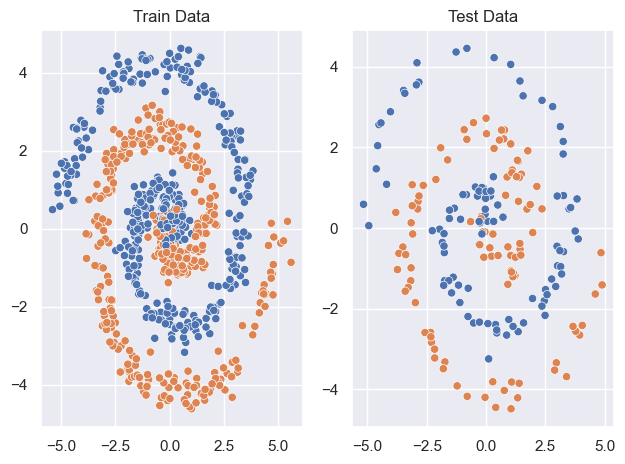

In [9]:
def split_coords(X):
    return X[:, 0].squeeze(), X[:, 1].squeeze()

X0_train, X1_train = split_coords(X_train)
X0_test, X1_test = split_coords(X_test)

fig, ax = plt.subplots(1,2)
sns.scatterplot(x=X0_train, y=X1_train, hue=y_train, ax=ax[0], legend=False)
sns.scatterplot(x=X0_test, y=X1_test, hue=y_test, ax=ax[1], legend=False)
ax[0].set_title('Train Data')
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('Test Data')
plt.tight_layout()
plt.show()

## Define the model [5 pts]

Define your model.  Create an instance of it.  Use `summarizer` to generate a model summary.

In [10]:
class SpiralColorClassifier(nn.Module):
    def __init__(self):
        super(SpiralColorClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 6),
            nn.ReLU(),
            nn.Linear(6,2),
        )
    def forward(self, x):
        return self.model(x)

model = SpiralColorClassifier()

summarizer(model, input_size = (50,2))
        

Layer (type (var_name))                            Input Shape          Output Shape         Param #
SpiralColorClassifier (SpiralColorClassifier)      [50, 2]              [50, 2]              --
├─Sequential (model)                               [50, 2]              [50, 2]              --
│    └─Linear (0)                                  [50, 2]              [50, 8]              24
│    └─ReLU (1)                                    [50, 8]              [50, 8]              --
│    └─Linear (2)                                  [50, 8]              [50, 8]              72
│    └─ReLU (3)                                    [50, 8]              [50, 8]              --
│    └─Linear (4)                                  [50, 8]              [50, 6]              54
│    └─ReLU (5)                                    [50, 6]              [50, 6]              --
│    └─Linear (6)                                  [50, 6]              [50, 2]              14
Total params: 164
Trainable params:

How many trainable parameters are in your model?

ANSWER HERE: 164

## Train the model [5 pts]

Configure the model training and do the training. Save the checkpoint file in MODELS_PATH.

**You should be able to achieve around 95% accuracy on the test data.**

In [29]:
device = get_device()
print(f'device:{device}')

device:mps


In [54]:
loss_func = nn.CrossEntropyLoss()
score_funcs = {'ACC':accuracy_score}
device = get_device() # from course package
ckpt_file = MODELS_PATH / 'HW1_SpiralColorClassifier.pt'

model = SpiralColorClassifier()

results_df = train_simple_network(model, 
                                  loss_func, 
                                  train_loader, 
                                  device=device, 
                                  epochs = 350, 
                                  lr = 0.05, 
                                  checkpoint_file=ckpt_file, 
                                  test_loader=test_loader,
                                  score_funcs = score_funcs,
                                  use_tqdm=True)

Epoch:   0%|          | 0/350 [00:00<?, ?it/s]

## Inspect convergence graphically [5 pts]

Load the checkpoint file and use it to plot training and test loss vs epoch and training and test accuracy vs epoch.

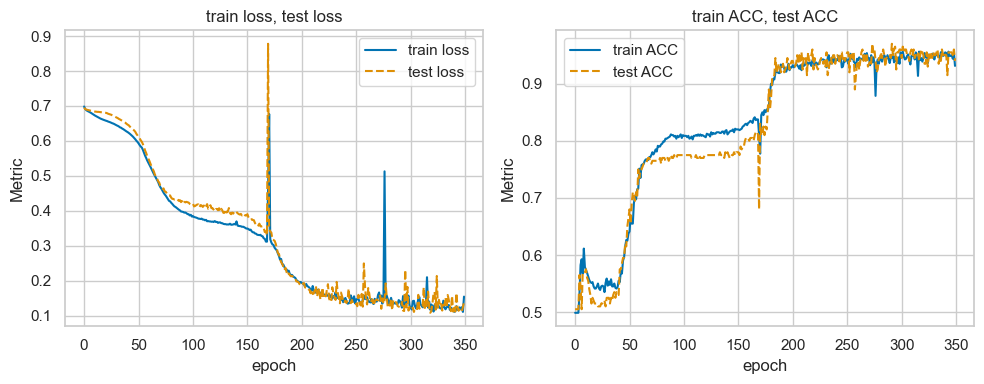

In [55]:
results_df = load_results(MODELS_PATH / 'HW1_SpiralColorClassifier.pt') # load results from checkpoint and returns data frame

plot_training_metrics(results_df,[['train loss', 'test loss'],['train ACC', 'test ACC']])

In [57]:
print(max(results_df["test ACC"]))

0.97


What is the maximum test accuracy found by your model?

ANSWER HERE: 0.98


## Visualize the model fit [5 pts]

Plot the fitted model as in the lesson.

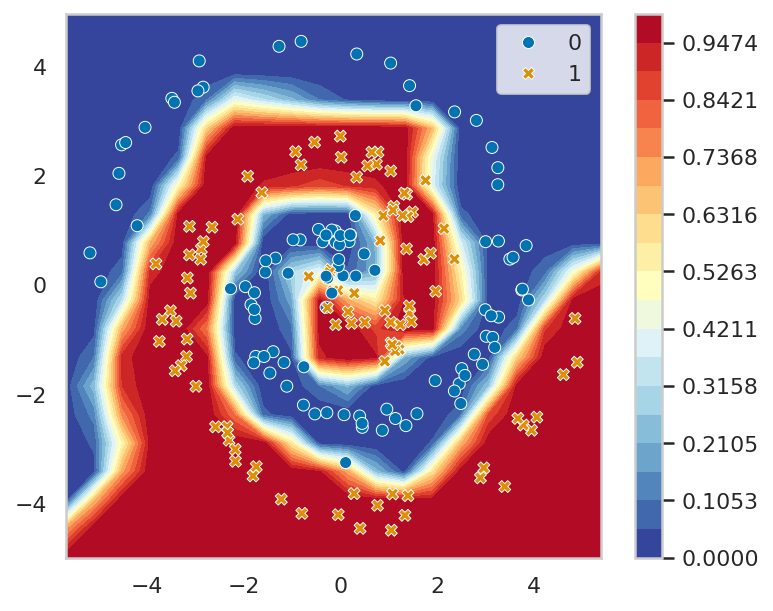

In [36]:
ckpt_file = MODELS_PATH / 'HW1_SpiralColorClassifier.pt'
model = load_model(SpiralColorClassifier, ckpt_file)

visualize2DSoftmax(X_test.numpy(), y_test.numpy(), model)

Comment on the quality of the fit.  Does the decision boundary accurately represent the separation of the classes or is there anything about it that seems incorrect?

ANSWER HERE: The fit is good overall. It struggles in the very center where the two classes are very tightly clustered together but the general shape seems to be correct. The curves aren't completely smooth and there are a few places where the decision boundry could have been drawn at a better coordinate but overall the model seems to be accurate. 

## Make predictions [5 pts]

Include a function for making predictions and find the probabilities and predicted labels for new points: (0,0), (0,2), and (0,4).


In [37]:
def predict_classes(points, model):
    """
    Predicts the class probabilities and labels for a given set of points using a trained model.

    Args:
        points (numpy.ndarray): An Nx2 array of x,y point coordinates.
        model: The trained model used for prediction.

    Returns:
        tuple: A tuple containing two numpy arrays. The first array contains the probabilities of the points belonging to the second class.
               The second array contains the predicted class labels (0 or 1) for the points.
    """
    # Convert numpy array to torch tensor
    tensor_points = torch.tensor(points, dtype=torch.float32)
    
    # Make predictions using the model
    with torch.no_grad():
        logits = model(tensor_points)
        probabilities = torch.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)
    
    # Convert predicted labels to numpy array
    predicted_labels = predicted_labels.numpy()
    
    return probabilities[:, 1].numpy(), predicted_labels

x = np.array([[0, 0], [0, 2], [0, 4]])
probs, labels = predict_classes(x, model)
print(f'Predicted Probabilities: {probs}\nPredicted Classes: {labels}')


Predicted Probabilities: [4.0169597e-01 9.8753881e-01 1.6720792e-07]
Predicted Classes: [0 1 0]
